In [101]:
# Subject:      NLP - gleaning topics from 2016 presidential debate transcripts 
# Date:         11/14/2019
# Name:         Sami Ahmed
# Worked with:  (solo, mostly consulted with John) 

**notebook objectives: topic modeling third approach: NMF, topic model by individual clusters out of Kmeans**

## imports/settings

In [2]:
# NLP related packages
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Import the necessary modules for LDA with gensim
# Terminal / Anaconda Navigator: conda install -c conda-forge gensim
from gensim import matutils, models
import scipy.sparse

#misc files/text processing
import pickle
import pandas as pd
import re
import collections
from itertools import cycle


# plotting
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt


#  pandas 
import pandas as pd
import seaborn as sns

# import sklearn
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle

# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']


# uses custom metis style sheet for notebooks
from IPython.core.display import HTML
HTML("""<link rel="stylesheet" href="https://soph.info/metis/nb.css" type="text/css"/>""")

Populating the interactive namespace from numpy and matplotlib


/Users/samiahmed/anaconda3/envs/metis/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
# set pandas options 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Loading pickled files

In [8]:
# unpickle speaker + text df
with open('check_lemm_df.pkl', 'rb') as f:
       check_lemm_df = pickle.load(f)

## Some cleaning 

In [ ]:
# data cleaning removing integers from corpus so I can run the countvectorizer 
corpus_check_lemm_df = check_lemm_df
corpus_check_lemm_df['Text'] = corpus_check_lemm_df['Text'].str.replace('\d+', '')
corpus_check_lemm_df = pd.DataFrame(corpus_check_lemm_df)
corpus_check_lemm_df['Text'] = pd.Series(corpus_check_lemm_df['Text'])
corpus_check_lemm_df['Text'] = corpus_check_lemm_df['Text'].apply(', '.join)

# pickle final df with speaker 
corpus_check_lemm_df.to_pickle('corpus_check_lemm_df.pkl')

## NMF model 

In [60]:
# function that gets the topic names out of the NMF output 

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [57]:
# ported over from LDA notebook 
# Document-term matrix, unigram round

cvn = CountVectorizer(stop_words=debate_list, max_df=4.0,min_df=30)
data_cvn = cvn.fit_transform(corpus_check_lemm_df['Text'])
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())

In [58]:
#  generate NMF model for a few topics 
nmf_model = NMF(4)
doc_topic = nmf_model.fit_transform(data_cvn)

In [61]:
display_topics(nmf_model, cvn.get_feature_names(), 10)


Topic  0
tax, pay, percent, cut, income, business, money, rate, flat, budget

Topic  1
isi, world, war, fight, deal, military, syria, obama, iran, attack

Topic  2
job, economy, million, law, family, wall, wage, street, money, create

Topic  3
care, health, insurance, money, veteran, affordable, act, cost, company, obamacare


**These topics are dramatically clearer than LDA (ran in separate notebook):**

Topic 0: Economy 

Topic 1: Foreign policy 

Topic 2: Economy (maybe more "the 1%" focused)  

Topic 3: Healthcare 

In [62]:
#  generate NMF model for 8 topics
nmf_model = NMF(8)
doc_topic = nmf_model.fit_transform(data_cvn)

In [63]:
display_topics(nmf_model, cvn.get_feature_names(), 10)


Topic  0
tax, pay, percent, cut, income, business, rate, money, flat, reform

Topic  1
isi, world, war, fight, syria, military, iraq, force, ground, attack

Topic  2
job, economy, wage, create, million, business, grow, lose, worker, manufacturing

Topic  3
care, health, insurance, affordable, veteran, act, cost, company, money, obamacare

Topic  4
law, gun, court, immigration, life, justice, border, supreme, use, child

Topic  5
wall, street, money, economy, million, bank, pay, billion, dollar, class

Topic  6
deal, iran, trade, nuclear, china, korea, north, bad, billion, weapon

Topic  7
security, social, money, cut, budget, national, medicare, benefit, debt, mean


## rerun LSA (my initial topic modeling approach, see LSA_and_text_cleaning notebook) for comparison to NMF


In [64]:
lsa = TruncatedSVD(8)
doc_topic_lsa = lsa.fit_transform(data_cvn)

In [65]:
display_topics(lsa, cvn.get_feature_names(), 8)


Topic  0
tax, job, percent, pay, world, money, economy, cut

Topic  1
tax, pay, percent, cut, income, business, rate, flat

Topic  2
care, health, job, million, insurance, law, money, wall

Topic  3
care, health, tax, insurance, money, isi, pay, affordable

Topic  4
job, care, health, world, isi, war, insurance, veteran

Topic  5
wall, street, money, pay, economy, million, world, percent

Topic  6
deal, iran, security, trade, nuclear, cut, social, china

Topic  7
security, social, money, cut, budget, fight, balance, washington


**Similar themes to NMF but more topic bleeding, so will move forward with NMF**

## LSA with bigrams  

In [67]:
# ported over from LDA notebook 
# Document-term matrix, bigrams this time, which you specify in the ngam_range

bi_cvn = CountVectorizer(stop_words=debate_list,min_df=20, max_df=1.0,ngram_range=(1,2), binary=True)
bi_data_cvn = bi_cvn.fit_transform(corpus_check_lemm_df['Text']) 
bi_data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())

/Users/samiahmed/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['malley'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [68]:
bi_data_cvn.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [69]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
bi_lsa = TruncatedSVD(7)
bi_doc_topic = bi_lsa.fit_transform(bi_data_cvn)

In [70]:
display_topics(bi_lsa, bi_cvn.get_feature_names(), 10)


Topic  0
job, world, tax, million, obama, economy, percent, money, try, day

Topic  1
tax, job, pay, percent, economy, million, money, income, rate, low

Topic  2
tax, world, isi, job, create, cut, middle, percent, war, economy

Topic  3
street, wall, wall street, world, middle, million, care, health, isi, class

Topic  4
wall, street, wall street, obama, barack, barack obama, million, hillary, economy, bank

Topic  5
obama, barack, barack obama, care, health, hillary, health care, policy, security, insurance

Topic  6
security, social, social security, wall, money, street, wall street, tax, cut, use


**desipte the bigrams still getting a decent amount of topic bleed in LSA**

## Clustering via Kmeans

In [9]:
# ported over from LDA notebook 
# Document-term matrix, running on single words not bigrams like in the previous section 

cvn = CountVectorizer(stop_words=debate_list, max_df=4.0,min_df=30)
data_cvn = cvn.fit_transform(corpus_check_lemm_df['Text'])
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())

/Users/samiahmed/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['malley'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [172]:
data_dtmn.shape

(9835, 887)

In [173]:
# making sure this shape mathes the count vectorized data (data_dtmn) 
corpus_check_lemm_df.shape

(9835, 2)

In [73]:
# initialize Kmeans algo, and fit on DTM (900+dimensional space)

true_k = 8
km_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(data_dtmn)
clusters = km_model.labels_.tolist()

In [74]:
# initialize Kmeans algo, and fit on DTM that has been SVD'ed (see below, we went down to 10dims)

true_k = 8
km_model_lsa = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(doc_topic_k)
clusters_lsa = km_model_lsa.labels_.tolist()

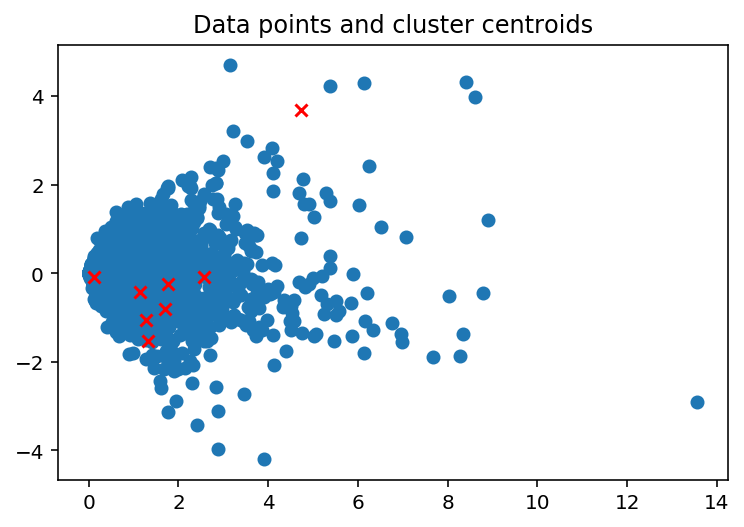

In [76]:
plt.scatter(doc_topic_k[:, 0], doc_topic_k[:, -1])
    
plt.scatter(km_model_lsa.cluster_centers_[:, 0], km_model_lsa.cluster_centers_[:, 1], c='red', marker='x')
    
plt.title('Data points and cluster centroids')
plt.show()

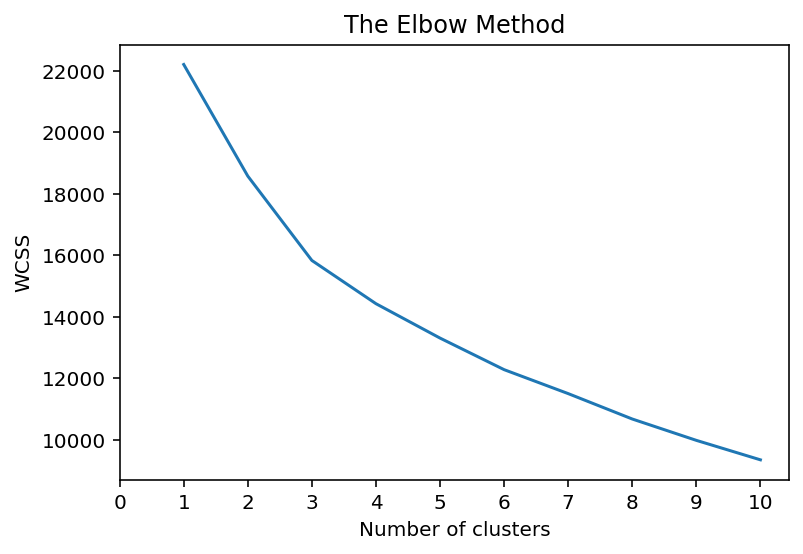

<Figure size 432x288 with 0 Axes>

In [77]:
# wcss= within cluster sum of errors

# Calculates the Within-Cluster-Sum of Squared Errors (WCSS) for different values of k, 
# choose the k for which WCSS becomes first starts to diminish noticeably. 
# In the plot of WSS-versus-k, this is visible as "the elbow"

# below is the kmeans fit on the truncated SVD 10dimensional space 

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(doc_topic_k)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
xticks(np.arange(0, 11, step=1))
plt.ylabel('WCSS')
plt.show()
plt.savefig('elbow')

In [79]:
# below is the kmeans fit on the massive 900+dimensional space out of the count vectorizer

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(data_cvn)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

**this is data running in a 10dimensional space, we are tackling the "curse of dimensionality" by moving our data 
from a 916 dimensional space (out of our count vectorizer) to a much smaller 10dim space through the SVD**

In [76]:
# shrinking our count vectorized data down to 10 dims

lsa_k = TruncatedSVD(10)
doc_topic_k = lsa_k.fit_transform(data_dtmn)

In [68]:

cluster_centers_lsa = km_model_lsa.cluster_centers_

In [78]:
# set cluster centers (for graph)

cluster_centers_10 = lsa_k.transform(km_model.cluster_centers_)

# set to hue in graph 

km_preds = km_model.predict(data_dtmn)

# plotting settings, these are commented out because they only need/should be ran once, otherwise the labels
# on your graph will get messed up 

# hue_range = ['cl_'+ str(x) for x in list(set(km_preds))]
# km_preds = ['cl_'+ str(x) for x in km_preds]



**seaborn plotting code for the 10dim space out of our truncated SVD is in the cell below**

**here we see each cluster and the surronding data**

**the conical shape of the data is a good indication that we're probably not capturing most of the variance**

**from the original data**

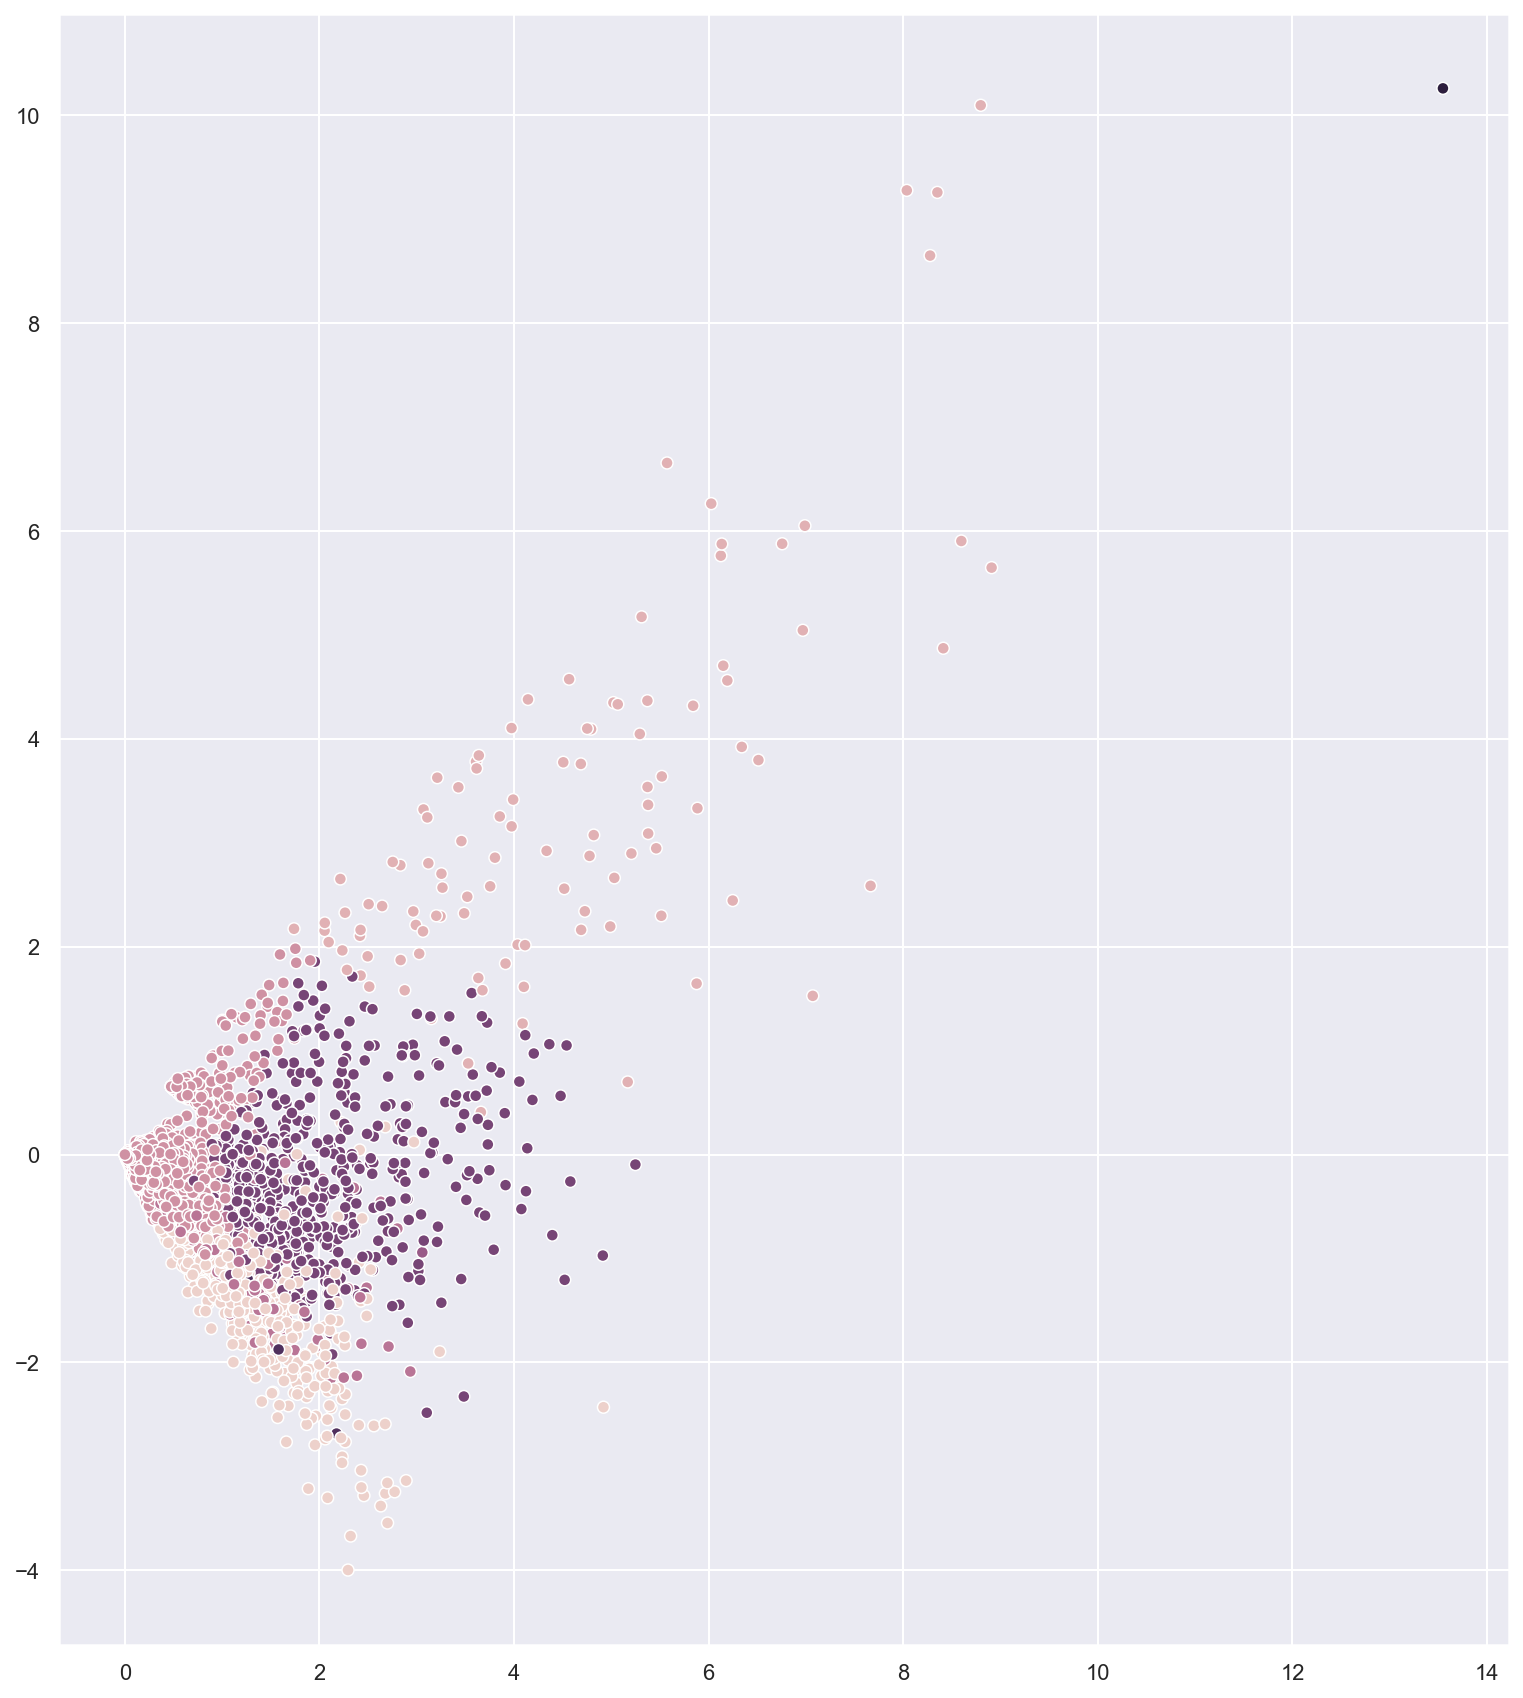

In [89]:
scatter = sns.scatterplot(doc_topic_k[:,0],doc_topic_k[:,1],hue=km_preds, alpha=1,legend=False)
#sns.scatterplot(cluster_centers_10[:,0],cluster_centers_10[:,1],hue=hue_range,size=20)
#sns.set(rc={'figure.figsize':(13,15)})

plt.savefig('scatter.png')




**Unfortunately, although the graph above looks great, it only explains about 15% of the variance of my data, as indicated by the var_ratio below, as a result I should consider an alternative visualization technique to accurate represent the variance**

In [84]:
sum(lsa_k.explained_variance_ratio_)

0.14418716576732862

**code below shows for each cluster how much of the data is falling into each cluster, we can see that because is 
a partioning algorithm, it must assign a datapoint to a cluster (why we have some clusters with only 1 datapoint)**

In [59]:
km_preds_df = pd.DataFrame(km_preds)
km_preds_df.iloc[:,0].value_counts()

2    8323
5     691
0     599
3     111
1     105
6       4
7       1
4       1
Name: 0, dtype: int64

In [63]:
km_preds_df.columns = ['cluster']

In [66]:
km_preds_df.to_csv('clusters_df.csv')

**NOTE below Kmeans does not do a good job of topic modeling because inherently it is not really adept at separating similar data, this is run on the data out of my truncated SVD**

In [88]:
print("Top terms per cluster:")
order_centroids = km_model_lsa.cluster_centers_.argsort()[:, ::-1]
terms = cvn.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :8]:
        print(' %s' % terms[ind]),
    print

**below Kmeans DOES a good job of topic modeling because inherently the data likely has good separation in the nature of its context. This is clusting based on the data straight out of my count vector**

In [86]:
print("Top terms per cluster:")
order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]
terms = cvn.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :8]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 world
 isi
 war
 deal
 iran
 fight
 military
 obama
Cluster 1:
 tax
 pay
 percent
 job
 cut
 income
 business
 money
Cluster 2:
 gun
 yes
 stage
 million
 point
 hillary
 start
 deal
Cluster 3:
 law
 court
 enforcement
 use
 gun
 supreme
 immigration
 enforce
Cluster 4:
 criminal
 political
 record
 money
 establishment
 begin
 corrupt
 billion
Cluster 5:
 job
 care
 money
 percent
 health
 million
 economy
 tax
Cluster 6:
 korea
 north
 missile
 nuclear
 defense
 weapon
 south
 sanction
Cluster 7:
 tax
 reform
 percent
 money
 bring
 infrastructure
 pay
 rebuild


## tSNE 

**t-distributed stochastic neighbor embedding (t-SNE). When reducing the dimensionality of a dataset, if we used the same Gaussian distribution for the data points and the map points, we would get an imbalance in the distribution of the distances of a point’s neighbors. This is because the distribution of the distances is so different between a high-dimensional space and a low-dimensional space. Yet, the algorithm tries to reproduce the same distances in the two spaces using a T-student distribution**

In [97]:
# X = data straight out of the count_vec 
X = data_dtmn

model = TSNE(n_components=2, random_state=0,verbose=0, perplexity=20,n_iter=5000,learning_rate=400)
low_data = model.fit_transform(X)

In [99]:
# plotting code for the low dim space out of tSNE

plt.figure(figsize=(15,15))
sns.scatterplot(low_data[:,0],low_data[:,1],s=15, hue=km_preds);

## expanded list of stop words 

In [6]:

# make dict of stop words, add common debate words that came up in initial topics out of LSA 

from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(['im','dont','need','want','senator','governor','know',
                                           'come','theyre','youre','going','think','said','thats',
                                           'just','make','did','got','mr','ms','ive','hey','yeah',
                                           'oh','ok','thank','john','jake','tonight','maria','anderson',
                                           'wolf','donald','youve','weve','secretary','chris', 'dana',
                                           'chris','martha','gentlemen','gentleman','woodruff','ifill','audience',
 'clinton',
 'sanders',
 'candidates',
 'tapper',
 'kasich',
 'rubio',
 'cruz',
 'trump',
 'dinan',
 'bash',
 'hewitt',
 'holt',
 "o'malley",
 'question',
 'mitchell',
 'dickerson',
 'carson',
 'bush',
 'strassel',
 'garrett',
 'regan',
 'seib',
 'jindal',
 'christie',
 'huckabee',
 'santorum',
 'unknown',
 'kelly',
 'baier',
 'wallace',
 'paul',
 'walker',
 'perry',
 'fiorina',
 'quintanilla',
 'fiorina',
 'harwood',
 'quick',
 'cramer',
 'santelli',
 'epperson',
 'pataki',
 'graham',
 'cooper',
 'chafee',
 'webb',
 'lemon',
 'lopez',
 'raddatz',
 'muir',
 'levesque',
 'mcelveen',
 'cavuto',
 'bartiromo',
 'blitzer',
 'ramos',
 'salinas',
 'ramos',
 'salinas',
 'tumulty',
 'sanders',
 'ramos',
 'clinton',
 'louis',
 'hemmer',
 'gilmore',
 'maccallum',
 'rubio',
 'cruz',
 'ham',
 'todd',
 'maddow',
 'cordes',
 'cooney',
 'obradovich',
 'cuomo',
 'trump',
 'kasich',
 'arrarás',
 'baker',
 'perry','sander',
 'country','president','reagan','ronald','doesnt','look','like','way','america','people','let','say','time','id',
                                            'government','debate','nation','state','american',
                                           'presidential','election','right','thing','talk','lot','big',
                                           'republican','democrat','able', 'issue',
'candidate',
 'year',
 'ask',
 'tell',
 'second',
 'work',
 'support','campaign',
 'united',
 'answer',
 'new',
 'believe', 'respond','great',
 'change',
 'vote',
 'good',
 'fact',
 'problem',
 'plan'])

debate_list = stop_words

**Below I rerun the most effective topic modeling approach fromy my experimentation (NMF) with a reduced stop_word list using the original data from my count vector but filtered by individual clusters**

## Subtopic modeling (on only terms that fall in cluster_5 of original vectorized data) 

In [408]:
# new dataframe, filtering the original vectorized matrix by cluster
# will topic model on just this cluster  

cluster_5_df = data_dtmn[(pd.Series(km_preds) == 'cl_5')]
cluster_5_df.reset_index(inplace=True)

In [153]:
# will try running TF-IDF instead of count vectorizer 
# Fantastic! TFIDF handles/realizes I am feeding it a DF that has already been count vectorized 

from sklearn.feature_extraction.text import TfidfVectorizer
TF = TfidfVectorizer()
TF_cl5 = TF.fit_transform(cluster_5_df)



In [150]:
# stop words tailored to my 

from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(['megyn','ready','terrible','ted'])

TF_stops = stop_words

In [154]:
#  generate NMF model for 8 topics

nmf_model_cl5 = NMF(8, random_state=6,max_iter=10000, solver= 'cd')
topics_cl5 = nmf_model_cl5.fit_transform(TF_cl5)
display_topics(nmf_model_cl5, TF.get_feature_names(), 8)


Topic  0
chinese, ill, senior, use, stay, clear, washington, stuff

Topic  1
open, remember, isi, citizen, clearly, regulation, fly, youd

Topic  2
case, declare, face, men, dc, weapon, save, russia

Topic  3
wealthy, kurd, independent, compete, detroit, ted, small, rate

Topic  4
parent, stop, college, turn, deficit, wealth, propose, criminal

Topic  5
islamic, relationship, particularly, individual, strategy, marijuana, laid, care

Topic  6
treat, immigration, manufacturing, megyn, ready, met, worker, terrible

Topic  7
opponent, completely, hope, soon, foreign, act, figure, early


## Subtopic modeling TAKE2 (on only terms that fall in cluster_1 of original vectorized data)   

In [97]:
# new dataframe, filtering the original vectorized matrix by cluster
# will topic model on just this cluster in section 

cluster_1_df = data_dtmn[(pd.Series(km_preds) == 'cl_1')]
cluster_1_df.reset_index(inplace=True)

In [99]:
# will try running TF-IDF instead of count vectorizer 
# Fantastic! TFIDF handles/realizes I am feeding it a DF that has already been count vectorized 

from sklearn.feature_extraction.text import TfidfVectorizer
TF = TfidfVectorizer(stop_words='english')
TF_cl1 = TF.fit_transform(cluster_1_df)



In [405]:
# stop words tailored to my 

from sklearn.feature_extraction import text 



stop_words = text.ENGLISH_STOP_WORDS.union(['im','dont','need','want','senator','governor','know',
                                           'come','theyre','youre','going','think','said','thats',
                                           'just','make','did','got','mr','ms','ive','hey','yeah',
                                           'oh','ok','thank','john','jake','tonight','maria','anderson',
                                           'wolf','donald','youve','weve','secretary','chris', 'dana',
                                           'chris','martha','gentlemen','gentleman','woodruff','ifill','audience',
                                           'increase', 'ben','use','somebody','base','page','check', 
                                            'recognize', 'particularly','easy','opening','end','close','read',
                                           'miss','wed','minute','tomorrow','example','term','guy','require',
                                           'presidency','head','na','ready','ago','maybe'])

TF_stops = stop_words

In [143]:
#  generate NMF model for 8 topics

nmf_model_cl1 = NMF(8, random_state=8, max_iter=10000)
topics_cl1 = nmf_model_cl1.fit_transform(TF_cl1)
display_topics(nmf_model_cl1, TF.get_feature_names(), 10)


Topic  0
peace, little, defend, appoint, negotiate, virtually, south, criminal, power, strategy

Topic  1
national, college, threaten, enormous, develop, drive, train, sit, code, putin

Topic  2
solution, history, critical, raise, wed, worried, appreciate, meet, presidency, benghazi

Topic  3
politician, proven, industry, replace, fair, small, loophole, price, commit, number

Topic  4
choose, hear, condition, ran, israel, possible, tuition, close, wait, term

Topic  5
explain, protection, truth, destroy, society, really, involve, kill, potential, choice

Topic  6
murder, policy, doubt, earth, doctor, medicaid, plane, dollar, honor, week

Topic  7
point, discuss, release, poor, stop, invest, read, daughter, reality, travel


**This topic was a bit all over the place, considering it is the cluster that accounts for the lionshare of data out of Kmeans, I ran the second biggest cluster above through this same TF-IDF + NMF workflow**

## Subtopic modeling TAKE3 (on only terms that fall in cluster_0 of original vectorized data)

In [105]:
# new dataframe, filtering the original vectorized matrix by the densest cluster (cluster 1)
# will topic model on just this cluster in section 

cluster_0_df = data_dtmn[(pd.Series(km_preds) == 'cl_0')]
cluster_0_df.reset_index(inplace=True)

In [137]:
# will try running TF-IDF instead of count vectorizer 
# Fantastic! TFIDF handles/realizes I am feeding it a DF that has already been count vectorized 

from sklearn.feature_extraction.text import TfidfVectorizer
TF = TfidfVectorizer()
TF_cl0 = TF.fit_transform(cluster_0_df)

In [161]:
#  generate NMF model for 8 topics

nmf_model_cl0 = NMF(8, random_state=6, max_iter=10000)
topics_cl0 = nmf_model_cl0.fit_transform(TF_cl0)
display_topics(nmf_model_cl0, TF.get_feature_names(), 8)


Topic  0
chinese, ill, senior, use, stay, clear, washington, stuff

Topic  1
open, remember, isi, citizen, clearly, regulation, fly, youd

Topic  2
case, declare, face, men, dc, weapon, save, russia

Topic  3
wealthy, kurd, independent, compete, detroit, ted, small, rate

Topic  4
parent, stop, college, turn, deficit, wealth, propose, criminal

Topic  5
islamic, relationship, particularly, individual, strategy, marijuana, laid, care

Topic  6
treat, immigration, manufacturing, megyn, ready, met, worker, terrible

Topic  7
opponent, completely, hope, soon, foreign, act, figure, early


**pretty fascinating to see the same topics as the cluster 5 results above**

## VADER

In [209]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

VADER analyses sentiments primarily based on certain key points such as punctuation, caps words, degree modifiers ('more/less good' for example), and conjunctions with latter half being sentiment (example 'the cat was soft but annoying' annoying = the sentiment). For this reason, I will provide it with my original text 


In [215]:
data_clean = pd.read_pickle('data_clean_debate.pkl')
data_clean_text = str(data_clean['Text'])

In [260]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [216]:
sentiment_analyzer_scores(data_clean_text)

0        good evening and thank you we are happy to wel...
1        we want to also extend our warm thanks to milw...
2                                                         
3        welcome senator great to see you and former se...
4                                                         
                               ...                        
13249    well as president i will make this a nation th...
13250                                                     
13251    i turned  in  and my first vote was for ronald...
13252                                                     
13253    that concludes this republican presidential de...
Name: Text, Length: 13254, dtype: object {'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.9723}


**sort of hard to interpret the results out of vader (what does majority of the data falls into compound sentiment really mean?)**

In [ ]:
dist = 1 - cosine_similarity(tfidf_matrix)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [ ]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
                  5: '#1b9e77', 6: '#d95f02', 7: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Nonsense', 
                 1: 'Economy', 
                 2: 'Nonsense2', 
                 3: 'Law Enforcement', 
                 4: 'Economy',
                 5: 'Issis', 
                 6: 'Taxcuts', 
                 7: 'Law Enforcement', 
                 8: 'Wallstreet'}

In [ ]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=cluster_centers_10)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'],df.ix[i]['title'],s=None, size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

## Appending candidate name (speaker) to subtopic modeling section above 

In [205]:
# make Speaker into DF so I can use PD merge, this way I can see the speaker associated with the topics I've modeled
# in the subtopic cells above 

speaker_df = pd.DataFrame(corpus_check_lemm_df['Speaker'])
speaker_df['index'] = speaker_df.index

In [236]:
# by default PD merge does a left join,  which is exactly what I need 

speaker_cluster5 = cluster_5_df.merge(speaker_df, left_on='index', right_on='index')

In [250]:
# exporting data for visualization in tableau 

speaker_cluster5_tableau = pd.DataFrame(speaker_cluster5.groupby(['Speaker','index']).sum().stack()).reset_index()
speaker_cluster5_tableau.columns = ['speaker','document','word','word_count']
speaker_cluster5_tableau.to_csv('speaker_cluster5_tableau.csv')
speaker_cluster5_tableau.to_pickle('speaker_cluster5_tableau.pkl')